In [1]:
import numpy as np
from tqdm import tqdm
import csv
import torch as ch
import torchvision.transforms as transforms
from timm.data import create_transform

from imagenet_dataloader import ImageNetwithLUAB, RRCFlipReturnParams

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from pathlib import Path
from ffcv.pipeline.operation import Operation
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, Squeeze, NormalizeImage, \
    RandomHorizontalFlip, ToTorchImage
from ffcv.fields.rgb_image import CenterCropRGBImageDecoder, \
    RandomResizedCropRGBImageDecoder
from ffcv.fields.basics import IntDecoder

from ffcv.pipeline.operation import Operation
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, Squeeze, NormalizeImage, \
    RandomHorizontalFlip, ToTorchImage
from ffcv.fields.rgb_image import CenterCropRGBImageDecoder, \
    RandomResizedCropRGBImageDecoder
from ffcv.fields.basics import IntDecoder


# Load vanilla ImageNet_AB

In [2]:
root_train = "/mnt/qb/datasets/ImageNet2012/train/"
xml_path = "/mnt/qb/work/oh/owl156/train_xml/"

input_size = 224

_, transform_2nd, transform_final = create_transform(
    input_size=input_size,
    is_training=True,
    auto_augment=None,
    color_jitter=0,
    re_prob=0,
    interpolation="bicubic",
    separate=True,
)

dataset_AB = ImageNetwithLUAB(
    root=root_train,
    xml_root=xml_path,
    num_classes=1000,
    transform=transforms.Compose([transform_2nd, transform_final]),
    pre_transform=RRCFlipReturnParams(
        size=input_size, scale=(0.08, 1), interpolation="bicubic"
    ),
)

# Load ffcv imagenet from 
'/mnt/qb/datasets/ffcv_imagenet_data/train_500_0.50_90.ffcv'


In [4]:
import timm
timm.data.constants.IMAGENET_DEFAULT_STD

(0.229, 0.224, 0.225)

In [5]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406]) * 255
IMAGENET_STD = np.array([0.229, 0.224, 0.225]) * 255
DEFAULT_CROP_RATIO = 224/256
    
def create_train_loader(train_dataset, subset):
    res = 192
    distributed = False
    this_device = 'cuda:0'
    train_path = Path(train_dataset)
    assert train_path.is_file()
    decoder = RandomResizedCropRGBImageDecoder((res, res))
    image_pipeline: List[Operation] = [
        decoder,
        RandomHorizontalFlip(),
        ToTensor(),
        ToDevice(ch.device(this_device), non_blocking=True),
        ToTorchImage(),
        NormalizeImage(IMAGENET_MEAN, IMAGENET_STD, np.float16)
    ]

    label_pipeline: List[Operation] = [
        IntDecoder(),
        ToTensor(),
        Squeeze(),
        ToDevice(ch.device(this_device), 
        non_blocking=True)
    ]

    loader = Loader(train_dataset,
                    batch_size=1024,
                    num_workers=2,
                    indices = subset,
                    order=OrderOption.SEQUENTIAL,
                    os_cache=1,
                    drop_last=False,
                    pipelines={
                        'image': image_pipeline,
                        'label': label_pipeline
                    },
                    distributed=distributed)
    return loader
ffcv_path = '/mnt/qb/datasets/ffcv_imagenet_data/train_500_0.50_90.ffcv'
subs_indices =  [i for i in range(2500) ] 
dataloader_ffcv = create_train_loader(ffcv_path, subs_indices)
_, (dataset_ffcv, labels) = next(enumerate(dataloader_ffcv))

In [9]:
import torchvision.transforms as T
transform = T.ToPILImage()

# Function to visualize an image given an index of the dataloader

In [10]:
def viz(img1, img2):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()

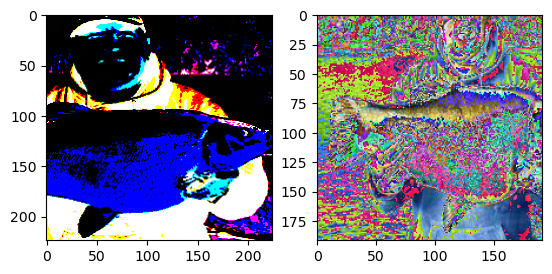

In [17]:
max_index = len(dataset_ffcv)
i = np.random.choice(np.arange(max_index), 1, replace=False)[0]
img_AB = dataset_AB[i][0]
img_ffcv = dataset_ffcv[i]
img_ffcv = transform(img_ffcv)
viz(img_AB, img_ffcv)

# Load different subsamples

In [18]:
selected_indices = np.load('data/selected.npy')
dataset_AB_selected = ch.utils.data.Subset(dataset_AB, selected_indices)


In [19]:
ffcv_path = '/mnt/qb/datasets/ffcv_imagenet_data/train_500_0.50_90.ffcv'
dataloader_ffcv_selected = create_train_loader(ffcv_path, selected_indices)
_, (dataset_ffcv_selected, labels) = next(enumerate(dataloader_ffcv_selected))

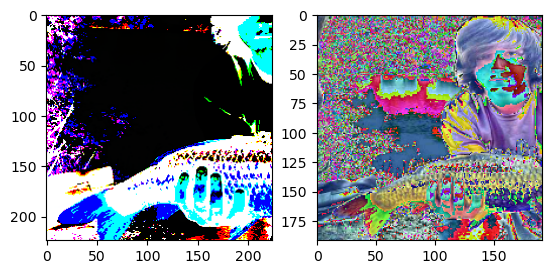

In [25]:
max_index = len(dataset_ffcv_selected)
i = np.random.choice(np.arange(max_index), 1, replace=False)[0]
img_AB = dataset_AB_selected[i][0]
img_ffcv = dataset_ffcv_selected[i]
img_ffcv = transform(img_ffcv)
viz(img_AB, img_ffcv)